# 1. Import libraries

In [2]:
import pandas as pd 
import math
import matplotlib.pyplot as plt 
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

# 2. Change the working directory

In [3]:
os.chdir('/Users/neda/Dropbox (PopGen)/tmp/egg_size_method_paper/scripts/')
os.getcwd()

'/Users/neda/Dropbox (PopGen)/tmp/egg_size_method_paper/scripts'

# 3. Functions

In [4]:
#This function computes the intercept&slope from the reference beads, converts TOF to size and appends size to the original data
def compute_append_size(eg_data):
    bead_200 = pd.read_excel('../data/Drosophila_eggs_OD1_5_1xPBS_26-03-2021/Ref_bead_26-03-2021.xlsx', sheet_name='200 um Beads')
    bead_430 = pd.read_excel('../data/Drosophila_eggs_OD1_5_1xPBS_26-03-2021/Ref_bead_26-03-2021.xlsx', sheet_name='430 um Beads')
    
    bead_200_flt = bead_200[bead_200['TOF'] > 600]
    bead_430_flt = bead_430[bead_430['TOF'] > 1800]
    
    x = np.array([200]*95+ [430]*96).reshape((-1, 1))
    x.shape
    y = np.array(list(bead_200_flt['TOF'])+list(bead_430_flt['TOF']))
    y.shape
    
    model = LinearRegression().fit(x, y)    
    sl=model.coef_[0]
    intc =  model.intercept_    
    size = (eg_data['TOF'] - intc) / sl
    eg_data['Size'] = size
    return(eg_data)

#this function estimates the best bandwidth for smoothing kernel density of the provided dataset 
#it then fits guassian density kernel to the provided dataset 
def find_best_bandwidth(eg_data):    
    #convert the egg size data to numpy array
    eg = np.array(eg_data['Size'])
    #this is a default set of bandwidth to test
    bandwidths = 20 ** np.linspace(-1, 1, 20)
    #assess the scores of different bandwidth to find the best FROM the pre-defined set
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),{'bandwidth': bandwidths}, cv=KFold(n_splits=5, shuffle=True, random_state=2))
    grid.fit(eg[:, None]);
    #this is your best bandwidth
    best_bw = grid.best_params_['bandwidth']
    return best_bw

#this function specifies a polynomial function with 8 orders. 
#Source: https://stackoverflow.com/questions/48469889/how-to-fit-a-polynomial-with-some-of-the-coefficients-constrained
def func(x, a, b, c, d, e, f, g, h, i):
  return a + b * x + c * x ** 2 + d * x ** 3 + e * x ** 4 + f * x ** 5 + g * x ** 6 + h * x ** 7+ i * x ** 8

#This function computes the area under a curve with a a polynomial function with 8 orders fit to it
def compute_area(x,coefs):
    area = sum(coefs[0] + coefs[1]*x + coefs[2]*x**2+ coefs[3]*x**3 + coefs[4]*x**4 +
               coefs[5]*x**5 + coefs[6]*x**6+ coefs[7]*x**7+ coefs[8]*x**8)
    return area
        
#This function extracts information (e.g. Ellipticalness index, EI, W: the highest recorded extinction by Biosorter for an object,
#L: the length of object, i.e. TOF, WL: the ratio of W to L which corresponds to the orientation of the elliptical object)
# The input data for this function are Biosorter output (the summary file and optical density).
def extract_optical_density(bio_data, opt_data):
    all_EI, all_W, all_L, all_WL = [], [], [], []
    #find the matching data in the 2 input files for each object using 'Id'
    for i in bio_data['Id']:
        #Each object has 4 optical density reading (each stored as a column in optical density file, we will 
        #only use the first one which corresponds to Extinction) 
        #remove zero values in the optical density data
        optden_nonzero = opt_data[str(i)][opt_data[str(i)]>0]    
        #if object is small (threshold of 11 is arbitrary), set all parameters to 0
        if len(optden_nonzero) <= 11:
            W, EI, L, WL = max(optden_nonzero), 0, 0,0
            all_EI.append(EI)
            all_W.append(W)
            all_L.append(L)
            all_WL.append(WL)   
        #if object is big compute parameters    
        if len(optden_nonzero) > 11:
            #L: corresponds to the recorded data for TOF
            L = len(optden_nonzero)
            #W: The Maximum recorded Extinction for an object
            W = max(optden_nonzero) - min(optden_nonzero)
            #Compute the Elliptical area using the estimated L and W. Note that it is divided by 2 because 
            #we will compare it with the area of an object under the optical density curve which is half an ellipse. 
            EllipArea = (math.pi*W*(L/2))/2
            #fit a curve to the optical density data
            X = np.linspace(0.5, L+0.5, L)
            ry = optden_nonzero - min(optden_nonzero)     
            popt_cons, popt_covar = curve_fit(func, X, ry)
            #compute the area under the optical density file
            Area = compute_area(X, popt_cons)
            #compute Ellipticalness index
            EI = Area/EllipArea  
            WL = W/L
            all_EI.append(EI)
            all_W.append(W)             
            all_L.append(L)
            all_WL.append(WL)
    return(all_EI, all_W, all_L, all_WL)   

#this function finds the border between egg debris/misaligned eggs and eggs.
#This function fits a guassian density kernel to data using the provided bandwidth. Assuming the data is bimodal,
#it then finds the first minimum point between the two modes which will be chosen as the border to separate modes
def find_border_KDE(eg_data, bw):
    #reshape the numpy array of egg size data
    egre = np.array(eg_data['Size'])[:, np.newaxis]
    #generate some data within the range of egg size
    egre_plot = np.linspace(0, 800, 1000)[:, np.newaxis]
    #Fit the Kernel Density model on the data.
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(egre)
    #Compute the log-likelihood of each sample under the model.
    log_dens = kde.score_samples(egre_plot) 
    #find the minima points in the dataset, i.e. the border between the two peaks
    #source: https://stackoverflow.com/questions/35094454/how-would-one-use-kernel-density-estimation-as-a-1d-clustering-method-in-scikit/35151947#35151947
    mi = argrelextrema(log_dens, np.less)[0] #(these are the y values, so their indices are the cut off for size)
    #plot the kernel density estimation
    fig, ax = plt.subplots(sharex=True, sharey=True)
    ax.plot(egre_plot[:, 0], np.exp(log_dens), color='maroon')
    #plot the border between the two peaks
    plt.vlines(x=egre_plot[mi][0], ymin=0, ymax=max(np.exp(log_dens)))
    plt.xlabel('Size')
    plt.ylabel('Density')           
    return egre_plot[mi][0][0]

#This function filters the Biosorter summary data using the estimated border
def remove_dust(eg_data, eg_bor):
    eg_data_flt = eg_data[eg_data['Size'] > eg_bor]
    return(eg_data_flt)

#this function is a compilation of multiple functions
#All the included functions are described above
def filter_dust_eggsize(eg_data):
    sam_bw = find_best_bandwidth(eg_data,)
    sam_bor = find_border_KDE(eg_data,sam_bw)
    sam_flt = remove_dust(eg_data, sam_bor)
    sam_flt_bw = find_best_bandwidth(sam_flt,)
    return (sam_flt,sam_flt_bw,sam_bor,sam_bw) #the order of output: filtered dataset, bandwidth of filtered dataset, border, bandwidth of unfiltered datset

#this function performs multiple filtering steps
#All the included functions are described above
#1. size, 2. EI, 3.W/L and 4. size
def filter_size_EI_WL_size(bio_data, opt_data):
    #remove columns that are not needed
    bio_data.drop(['Plate', 'Row', 'Column', 'Source well', 'Clog','PC Extinction',
                  'PC BFP','PC GFP','PC dsRED', 'Unnamed: 26'], inplace=True, axis=1)
    
    bio_data_sz = compute_append_size(bio_data)
    bio_data_sz['EI'],bio_data_sz['W'], bio_data_sz['L'], bio_data_sz['W/L']= extract_optical_density(bio_data_sz, opt_data)       
    bio_data_flt, bio_data_flt_bw, bio_data_bor, bio_data_bw = filter_dust_eggsize(bio_data_sz)
    
    #filter for the median of EI and W/L
    med_EI=np.median(bio_data_flt['EI'])
    std_EI=np.std(bio_data_flt['EI'])
    bio_data_flt2 = bio_data_flt[(bio_data_flt['EI'] >= med_EI-(std_EI/2)) & (bio_data_flt['EI'] <= med_EI+(std_EI/2))]
    
    med_WL=np.median(bio_data_flt['W/L'])
    std_WL=np.std(bio_data_flt['W/L'])
    bio_data_flt3 = bio_data_flt2[(bio_data_flt2['W/L'] >= med_WL-(std_WL/2)) & (bio_data_flt2['W/L'] <= med_WL+(std_WL/2))]
    
    bio_data_flt4, bio_data_flt_bw, bio_data_bor, bio_data_bw = filter_dust_eggsize(bio_data_flt3)
    
    return(bio_data_flt,bio_data_flt2,bio_data_flt3,bio_data_flt4, bio_data_flt_bw, bio_data_bor, bio_data_bw)


# 4. Step by step process of filtering Biosorter runs

## 4.1 Input files

### 4.1.1. The first file is Biosorter output that contains information about TOF, Extinction and fluorescence absorbance (summary file).

In [5]:
Dsim196 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim196.txt')

In [6]:
Dsim196.head()

,Id,Time,Plate,Row,Column,Source well,Clog,Sorted status,In Regions,TOF,...,PH BFP,PW BFP,PC BFP,PH GFP,PW GFP,PC GFP,PH dsRED,PW dsRED,PC dsRED,Unnamed: 26
0,1,19645575,NaN,0.0,0.0,NaN,N,0.0,0.0,56.0,...,136.0,56.0,NaN,1376.0,0.0,NaN,80.0,56.0,NaN,NaN
1,2,19645733,NaN,0.0,0.0,NaN,N,0.0,0.0,176.0,...,200.0,176.0,NaN,2208.0,0.0,NaN,112.0,176.0,NaN,NaN
2,3,19645750,NaN,0.0,0.0,NaN,N,0.0,0.0,64.0,...,20.0,48.0,NaN,264.0,0.0,NaN,72.0,56.0,NaN,NaN
3,4,19646012,NaN,0.0,0.0,NaN,N,0.0,100000000.0,296.0,...,5620.0,296.0,NaN,61332.0,296.0,NaN,2696.0,296.0,NaN,NaN
4,5,19646073,NaN,0.0,0.0,NaN,N,0.0,0.0,56.0,...,128.0,56.0,NaN,1128.0,0.0,NaN,92.0,56.0,NaN,NaN


### We remove rows at the end of the file about specifications of each run that are not needed.

In [7]:
Dsim196=Dsim196.drop(Dsim196.index[18258:])

### 4.1.2 The second file contains the optical density data

### This file contains columns that correspond to each object in the summary file. Each object has 4 corresponding columns. We only need the first one which corresponds to Extinction, the other 3 correspond to 3 fluorescence laser.

In [8]:
Dsim196_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim196_prf.txt')

### We remove the columns that are not needed

In [9]:
Dsim196.drop(['Plate', 'Row', 'Column', 'Source well', 'Clog','PC Extinction',
                  'PC BFP','PC GFP','PC dsRED', 'Unnamed: 26'], inplace=True, axis=1)

### 4.2 Compute size using TOF

### Then using function 'compute_append_size' we convert TOF to size (μm). 

In [10]:
Dsim196_sz = compute_append_size(Dsim196)

In [11]:
Dsim196_sz.head()

,Id,Time,Sorted status,In Regions,TOF,Extinction,BFP,GFP,dsRED,PH Extinction,PW Extinction,PH BFP,PW BFP,PH GFP,PW GFP,PH dsRED,PW dsRED,Size
0,1,19645575,0.0,0.0,56.0,2.72,0.07,0.62,0.04,4220.0,56.0,136.0,56.0,1376.0,0.0,80.0,56.0,92.209428
1,2,19645733,0.0,0.0,176.0,11.20,0.26,2.68,0.16,5836.0,176.0,200.0,176.0,2208.0,0.0,112.0,176.0,112.409528
2,3,19645750,0.0,0.0,64.0,2.84,0.01,0.05,0.02,3684.0,64.0,20.0,48.0,264.0,0.0,72.0,56.0,93.556101
3,4,19646012,0.0,100000000.0,296.0,30.70,10.60,139.00,6.50,11052.0,296.0,5620.0,296.0,61332.0,296.0,2696.0,296.0,132.609629
4,5,19646073,0.0,0.0,56.0,3.12,0.07,0.68,0.04,5048.0,56.0,128.0,56.0,1128.0,0.0,92.0,56.0,92.209428


### 4.3 Extract features from the optical density data.

### We use function **extract_optical_density** to extract features from the optical density data.

### This function finds the optical density data corresponding to each objects using 'Id'.  

### First, we remove zero values trailing the optical density for each object. Then, if the length of remaining data is 11 or equal (this value is arbitrary) we set ellipticalness index value and width to length ratio to 0. For the remaining objects with data length more than 11, we compute L (which is the length of recorded data points),  W (which is the difference between the minimum and maximum recorded value, this corresponds to the highest recorded value), EllipArea (Which is the area of an ellipse divided by 2 since the optical density of each object is half of the ellipse). We then fit a polynomial function with 8 order to the optical profile of each object and compute the area under this fitted curve. EI is computed as the ratio of the area under the fitted curve to the optical density data to the area of the nearest ellipse.


In [12]:
Dsim196_sz['EI'],Dsim196_sz['W'], Dsim196_sz['L'], Dsim196_sz['W/L'] = extract_optical_density(Dsim196_sz, Dsim196_opt)


### 4.4 Filter debris particles
 
### The initial filtering step is to remove very small objects which are mostly dust and yeast particles (less than 200 μm) using function 'filter_dust_eggsize'
 
### First we identify the best bandwidth for estimating the kernel density distribution by scanning 20 bandwidth and ultimately choosing the one with highest score. 

### Second, we identify the threshold for separating debris and eggs. For this, we first fit KDE on dataset using the best bandwidth identified in the previous step. Then we find all the points where the density decreases (this should correspond to valleys/pits in the curve) and choose the first pit as the threshold for removing the debris. A plot will be generated at this point for visual inspection of the chosen border. 
 
### In some cases the threshold doesn't seem to properly separating dust from eggs, since there will be more filtering steps ahead, we can ignore it for now. At the end of all filtering steps we will plot the size distribution and the chosen borders again. If the final chosen border doesn't seem realistic visually, further investigation is required. 

### Third, we filter the dataset using the identified border in the previous step to remove the debris. 

### Forth, we compute the best bandwidth for estimating the kernel density distribution for the filtered dataset.

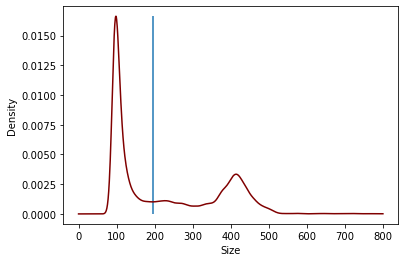

In [13]:
Dsim196_flt, Dsim196_flt_bw, Dsim196_bor, Dsim196_bw = filter_dust_eggsize(Dsim196_sz)
#plt.savefig('../plots/final_plots/size_dist_filter_Dsim196_border1.jpeg', dpi=100,format='jpeg', bbox_inches = 'tight')
#plt.savefig('../plots/final_plots/size_dist_filter_Dsim196_border1.svg', dpi=100,format='svg', bbox_inches = 'tight')


#### The blue line shows the chosen border to remove egg debris.

### 4.4 Filter misaligned eggs

### Let's have a look at the distribution of EI, W, L and W/L

(array([1315., 3709., 1407.,  583.,  391.,  234.,  112.,   44.,   16.,
           5.]),
 array([  9.47368421,  81.1495716 , 152.825459  , 224.50134639,
        296.17723378, 367.85312118, 439.52900857, 511.20489596,
        582.88078335, 654.55667075, 726.23255814]),
 <BarContainer object of 10 artists>)

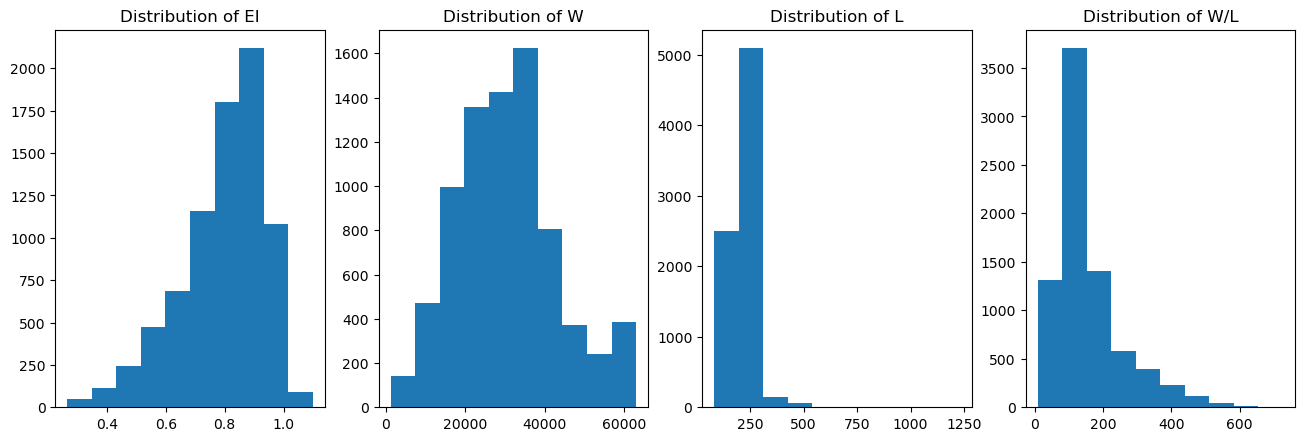

In [14]:
fig , ax = plt.subplots(nrows=1, ncols=4,sharex=True, sharey=True,figsize=(16,5),dpi=100, facecolor='w', edgecolor='k')    
ax=plt.subplot(1,4,1)
plt.title('Distribution of EI')
plt.hist(Dsim196_flt['EI'])
ax=plt.subplot(1,4,2)
plt.title('Distribution of W')
plt.hist(Dsim196_flt['W'])
ax=plt.subplot(1,4,3)
plt.title('Distribution of L')
plt.hist(Dsim196_flt['L'])
ax=plt.subplot(1,4,4)
plt.title('Distribution of W/L')
plt.hist(Dsim196_flt['W/L'])


### We filter for the objects with EI and W/L outside median +/- sd/2

In [15]:
med_EI=np.median(Dsim196_flt['EI'])
std_EI=np.std(Dsim196_flt['EI'])

med_WL=np.median(Dsim196_flt['W/L'])
std_WL=np.std(Dsim196_flt['W/L']) 


In [16]:
Dsim196_flt2 = Dsim196_flt[(Dsim196_flt['EI'] >= med_EI-(std_EI/2)) & (Dsim196_flt['EI'] <= med_EI+(std_EI/2))]    
Dsim196_flt3 = Dsim196_flt2[(Dsim196_flt2['W/L'] >= med_WL-(std_WL/2)) & (Dsim196_flt2['W/L'] <= med_WL+(std_WL/2))]


### Check the distribution of EI, W,L and W/L after filtering

(array([196., 194., 232., 228., 271., 277., 232., 122.,  71.,  61.]),
 array([ 83.27659574,  93.06833916, 102.86008257, 112.65182598,
        122.44356939, 132.2353128 , 142.02705621, 151.81879962,
        161.61054303, 171.40228644, 181.19402985]),
 <BarContainer object of 10 artists>)

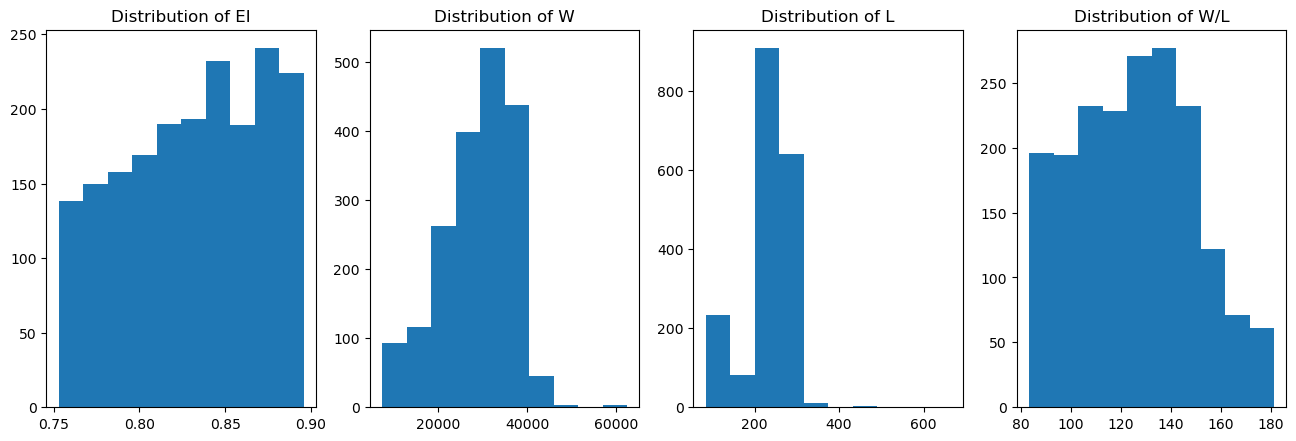

In [17]:
fig , ax = plt.subplots(nrows=1, ncols=4,sharex=True, sharey=True,figsize=(16,5),dpi=100, facecolor='w', edgecolor='k')    
ax=plt.subplot(1,4,1)
plt.title('Distribution of EI')
plt.hist(Dsim196_flt3['EI'])
ax=plt.subplot(1,4,2)
plt.title('Distribution of W')
plt.hist(Dsim196_flt3['W'])
ax=plt.subplot(1,4,3)
plt.title('Distribution of L')
plt.hist(Dsim196_flt3['L'])
ax=plt.subplot(1,4,4)
plt.title('Distribution of W/L')
plt.hist(Dsim196_flt3['W/L'])


### Check the size distribution of filtered objects

(array([234.,  81., 910., 642.,  12.,   1.,   3.,   0.,   0.,   1.]),
 array([195.90327783, 274.01033374, 352.11738965, 430.22444556,
        508.33150147, 586.43855739, 664.5456133 , 742.65266921,
        820.75972512, 898.86678103, 976.97383694]),
 <BarContainer object of 10 artists>)

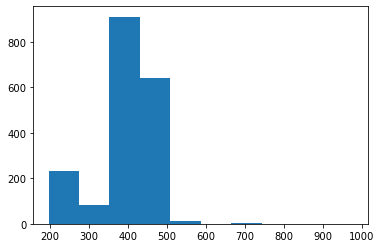

In [18]:
plt.hist(Dsim196_flt3['Size'])

### Notice that there are still some small objects, thus we will do a second size filtering

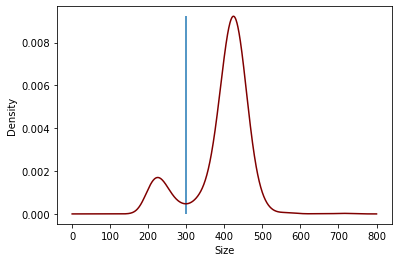

In [19]:
Dsim196_flt4, Dsim196_flt_bw, Dsim196_bor, Dsim196_bw = filter_dust_eggsize(Dsim196_flt3)
#plt.savefig('../plots/final_plots/size_dist_filter_Dsim196_border2.jpeg', dpi=100,format='jpeg', bbox_inches = 'tight')
#plt.savefig('../plots/final_plots/size_dist_filter_Dsim196_border2.svg', dpi=100,format='svg', bbox_inches = 'tight')



### To visualize the effect of each filtering step, we plot the size distribution after both filtering steps

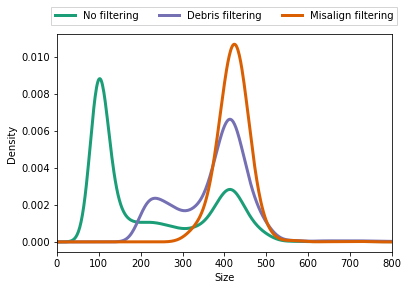

In [37]:
all_eg_data_subset = [Dsim196_sz, Dsim196_flt, Dsim196_flt4]
colors_subset = ['#1b9e77','#7570b3','#d95f02'] 
labels_subset = ['No filtering','Debris filtering','Misalign filtering']

all_bw = [Dsim196_flt_bw] * 3

fig, ax = plt.subplots(sharex=True, sharey=True)
for ind,eg_data in enumerate(all_eg_data_subset):
    #reshape the numpy array of egg size data
    egre = np.array(eg_data['Size'])[:, np.newaxis]
    #generate some data within the range of egg size
    egre_plot = np.linspace(0, 1600, 1000)[:, np.newaxis]
    #Fit the Kernel Density model on the data.
    kde = KernelDensity(kernel='gaussian', bandwidth=np.mean(all_bw)).fit(egre)
    #Compute the log-likelihood of each sample under the model.
    log_dens = kde.score_samples(egre_plot)             
    ax.plot(egre_plot[:, 0], np.exp(log_dens), color=colors_subset[ind], label=labels_subset[ind], linewidth = 3)
    #plot the border between the two peaks
plt.xlabel('Size')
plt.ylabel('Density') 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=3, fancybox=False, shadow=False)  
plt.xlim(0,800)
plt.savefig('../plots/final_plots/size_dist_filter_Dsim196_rev.jpeg', dpi=100,format='jpeg', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/size_dist_filter_Dsim196_rev.svg', dpi=100,format='svg', bbox_inches = 'tight')


### Seeing the plot, it is clear that the filtering steps remove the small objects and those with incorrect alignment, and not large objects. 